# Bayesian seats model

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-setup" data-toc-modified-id="Python-setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python setup</a></span></li><li><span><a href="#Get-the-data" data-toc-modified-id="Get-the-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get the data</a></span></li><li><span><a href="#Diagnostics" data-toc-modified-id="Diagnostics-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Diagnostics</a></span></li><li><span><a href="#Visualisations" data-toc-modified-id="Visualisations-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Visualisations</a></span><ul class="toc-item"><li><span><a href="#Seats-won" data-toc-modified-id="Seats-won-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Seats won</a></span></li><li><span><a href="#House-outcome" data-toc-modified-id="House-outcome-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>House outcome</a></span></li></ul></li></ul></div>

## Python setup

In [1]:
# Data science imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import arviz as az
import stan # install with pip - conda is problematic on the M1 MBP
print(f'Stan version: {stan.__version__}')
print(f'ArviZ version: {az.__version__}')

# system imports
import pathlib

Stan version: 3.3.0
ArviZ version: 0.11.4


In [2]:
# enable pystan on jupyter notebook
import nest_asyncio
nest_asyncio.apply()

In [3]:
# plotting stuff
plt.style.use('./markgraph.mplstyle')

CHART_DIR = '../charts'
pathlib.Path(CHART_DIR).mkdir(parents=True, exist_ok=True)
CHART_DIR += '/'

In [4]:
# data locations
SEAT_HISTORY_FILE = '../data/Seat History.csv'

## Get the data

Note: the data was produced by the "Realtionship between votes and seats" notebook.

In [5]:
def fix_column_names(t: pd.DataFrame) -> pd.DataFrame:
    """Replace 'Unnamed' column names with ''."""
    
    replacements = {}
    for c in t.columns:
        if 'Unnamed' in c[1]:
            replacements[c[1]] = ''
    if replacements:
        t = t.rename(columns=replacements, level=1)
    return t

In [6]:
# Load historical elections data
seat_history = pd.read_csv(SEAT_HISTORY_FILE, header=[0, 1], 
                           index_col=0, parse_dates=[0], )
seat_history = fix_column_names(seat_history)
seat_history.index.dtype

dtype('<M8[ns]')

In [7]:
seat_history.columns

MultiIndex([(               'Primary vote',   'ALP'),
            (               'Primary vote',  'L+NP'),
            (               'Primary vote',  'Oth.'),
            (                   '2PP vote',   'ALP'),
            (                   '2PP vote',  'L+NP'),
            (                      'Seats',   'ALP'),
            (                      'Seats',  'L+NP'),
            (                      'Seats',  'Oth.'),
            (                      'Seats', 'Total'),
            ('Governing party at election',      ''),
            (            'Governing since',      ''),
            (             'PM at election',      ''),
            (              'Winning party',      ''),
            (                      'Notes',      ''),
            (             'log gov period',      ''),
            (                     'winner',      ''),
            (      'Govt 2pp votes margin',      ''),
            (          'Govt seats margin',      '')],
           )

In [8]:
# use recent history only
seat_history = seat_history[seat_history.index.year >= 1984]
len(seat_history)

13

In [9]:
SEATS_NEXT_PARLIAMENT = 151
WIN_THRESHOLD = 75.5 # which will round up to 76 ...
seats_data = {

    'n_seats': SEATS_NEXT_PARLIAMENT,
    'win_threshold': WIN_THRESHOLD,
    'tpp': 0.47, # Still to code a polling model

    'n_history': len(seat_history),
    'seats': seat_history['Govt seats margin'].values,
    'votes': seat_history['Govt 2pp votes margin'].values,
    
    'others': ((seat_history[('Seats',  'Oth.')] 
               / seat_history[('Seats', 'Total')]).to_list()),
}

In [10]:
seats_model = """
data {
    real<lower=0,upper=1> tpp; // STILL TO CODE: from polls to tpp
    
    real<lower=1> n_seats;     // number of seats in parliament next election
    real<lower=0,upper=n_seats> win_threshold; // account for rounding to ints
    
    int<lower=1> n_history;    // length of election history
    vector<lower=-1,upper=1>[n_history] seats;  // Coalition seats margin (response)
    vector<lower=-1,upper=1>[n_history] votes;  // Coalition votes margin (inputs)

    vector<lower=0,upper=1>[n_history] others;
}

parameters {
    // historical relationship between 2pp votes and seats
    real slope;
    real intercept;
    real<lower=0> sigma;
    
    // historical relationship for other parties in house
    // auto regressive, this year is much like last year
    real a;
    real b;
    real<lower=0> s;
    
    // TO DO - model historic polling accuracy for predicting 2pp vote share
}

model {
    // priors on vote difference
    intercept ~ normal(0, 1);
    slope ~ normal(3, 1);
    sigma ~ cauchy(0, 10);

    // priors on auto-regressive non-major-party seat proportion
    a ~ normal(0, 0.1);
    b ~ normal(1, 0.1);
    s ~ cauchy(0, 10);

    // linear regression from 2pp vote difference to seats difference
    // TO DO - think about a fatter-tails distribution eg. student_t
    seats ~ normal(intercept + (slope * votes), sigma);
    
    // autoregressive(1) model for proportion of non-major-party seats
    for(i in 2:n_history) {
        others[i] ~ normal(a + b*others[i-1], s);
    }
    
    // TO DO - model historic polling accuracy for predicting 2pp vote share
}

generated quantities {
    real<lower=0,upper=n_seats> other_seats;
    other_seats = (a + b*others[n_history]) * n_seats;
    
    real<lower=0,upper=n_seats> available_seats;
    available_seats = n_seats - other_seats;

    real<lower=0,upper=n_seats> government_seats;
    government_seats = ((available_seats / 2) 
                        + (((tpp - (1.0 - tpp)) * slope) + intercept) 
                        * (available_seats / 2));

    real<lower=0,upper=n_seats> opposition_seats;
    opposition_seats = (available_seats - government_seats);
    
    int<lower=0,upper=1> government_wins;
    government_wins = government_seats > win_threshold ? 1 : 0;

    int<lower=0,upper=1> opposition_wins;
    opposition_wins = opposition_seats > win_threshold ? 1 : 0;
    
    int<lower=0,upper=1> hung_parliament;
    hung_parliament = (government_wins == 0 && opposition_wins == 0) ? 1 : 0;
}
"""

In [11]:
posterior = stan.build(seats_model, data=seats_data)

Building: 0.2s
Building: 0.3s
Building: 0.4s
Building: 0.5s
Building: 0.6s
Building: 0.7s
Building: 0.8s
Building: 0.9s
Building: 1.0s
Building: 1.1s
Building: 1.2s
Building: 1.3s
Building: 1.4s
Building: 1.5s
Building: 1.6s
Building: 1.7s
Building: 1.8s
Building: 1.9s


In file included from /Users/bryanpalmer/Library/Caches/httpstan/4.6.1/models/xzg547x7/model_xzg547x7.cpp:2:
In file included from /Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core.hpp:28:
In file included from /Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/operator_addition.hpp:6:
/Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/math/prim/err/check_matching_dims.hpp:33:8: warning: unused variable 'error' [-Wunused-variable]
  bool error = false;
       ^
/Users/bryanpalmer/miniforge3/lib/python3.9/site-packages

Building: 2.0s
Building: 2.1s
Building: 2.2s
Building: 2.3s
Building: 2.4s
Building: 2.5s
Building: 2.6s
Building: 2.7s


In file included from /Users/bryanpalmer/Library/Caches/httpstan/4.6.1/models/xzg547x7/model_xzg547x7.cpp:2:
In file included from /Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:26:
/Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/beta.hpp:70:32: warning: lambda capture 'b' is not used [-Wunused-lambda-capture]
                           [a, b, digamma_ab](auto& vi) mutable {
                             ~~^
/Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/beta.hpp:96:39: warning: lambda capture

Building: 2.8s
Building: 2.9s
Building: 3.0s
Building: 3.1s


In file included from /Users/bryanpalmer/Library/Caches/httpstan/4.6.1/models/xzg547x7/model_xzg547x7.cpp:2:
In file included from /Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:54:
In file included from /Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9:
In file included from /Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7:
In file included from /Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/math/prim/fun.hpp:120:
/Users/bryanpal

Building: 3.2s
Building: 3.3s
Building: 3.4s
Building: 3.5s


In file included from /Users/bryanpalmer/Library/Caches/httpstan/4.6.1/models/xzg547x7/model_xzg547x7.cpp:2:
In file included from /Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:121:
/Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/matrix_power.hpp:52:24: warning: comparison of integers of different signs: 'size_t' (aka 'unsigned long') and 'const int' [-Wsign-compare]
  for (size_t i = 2; i <= n; ++i) {
                     ~ ^  ~
In file included from /Users/bryanpalmer/Library/Caches/httpstan/4.6.1/models/xzg547x7/model_xzg547x7.cpp:2:

Building: 3.6s
Building: 3.8s
Building: 3.9s
Building: 4.0s
Building: 4.1s
Building: 4.2s
Building: 4.3s
Building: 4.4s
Building: 4.5s
Building: 4.6s
Building: 4.7s
Building: 4.8s
Building: 4.9s
Building: 5.0s
Building: 5.1s
Building: 5.2s


In file included from /Users/bryanpalmer/Library/Caches/httpstan/4.6.1/models/xzg547x7/model_xzg547x7.cpp:2:
In file included from /Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:11:
In file included from /Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/math/rev/functor.hpp:28:
/Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/math/rev/functor/operands_and_partials.hpp:29:1: warning: 'ops_partials_edge' defined as a class template here but previously declared as a struct template; this is valid, but may result in linker errors under the Microsoft C++ ABI [-Wmismatched-tags]
class ops_partials_edge<double, var> {
^
/Users/bryanpalmer/miniforge3

Building: 5.3s
Building: 5.4s
Building: 5.5s


In file included from /Users/bryanpalmer/Library/Caches/httpstan/4.6.1/models/xzg547x7/model_xzg547x7.cpp:2:
In file included from /Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:13:
In file included from /Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob.hpp:139:
/Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/hmm_marginal.hpp:26:13: warning: unused variable 'n_states' [-Wunused-variable]
  const int n_states = omegas.rows();
            ^


Building: 5.6s
Building: 5.7s
Building: 5.8s


In file included from /Users/bryanpalmer/Library/Caches/httpstan/4.6.1/models/xzg547x7/model_xzg547x7.cpp:2:
In file included from /Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:13:
In file included from /Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob.hpp:307:
In file included from /Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/skew_double_exponential_ccdf_log.hpp:5:
/Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/skew_double_exponential_lccdf.h

Building: 5.9s
Building: 6.0s


/Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/model/indexing/assign.hpp:538:21: warning: comparison of integers of different signs: 'int' and 'std::vector<int>::size_type' (aka 'unsigned long') [-Wsign-compare]
  for (int i = 0; i < col_idx.ns_.size(); ++i) {
                  ~ ^ ~~~~~~~~~~~~~~~~~~
/Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/model/indexing/assign.hpp:637:21: warning: comparison of integers of different signs: 'int' and 'std::vector<int>::size_type' (aka 'unsigned long') [-Wsign-compare]
  for (int j = 0; j < col_idx.ns_.size(); ++j) {
                  ~ ^ ~~~~~~~~~~~~~~~~~~
In file included from /Users/bryanpalmer/Library/Caches/httpstan/4.6.1/models/xzg547x7/model_xzg547x7.cpp:2:
In file included from /Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:17:
In file included from /Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/inc

Building: 6.1s
Building: 6.2s
Building: 6.3s
Building: 6.4s
Building: 6.5s
Building: 6.6s
Building: 6.7s
Building: 6.8s


In file included from /Users/bryanpalmer/Library/Caches/httpstan/4.6.1/models/xzg547x7/model_xzg547x7.cpp:2:
In file included from /Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core.hpp:28:
/Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/operator_addition.hpp:80:21: warning: lambda capture 'b' is not used [-Wunused-lambda-capture]
      [avi = a.vi_, b](const auto& vi) mutable { avi->adj_ += vi.adj_; });
                    ^
/Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/grad_inc_beta.hpp:45:43: no

Building: 6.9s
Building: 7.0s
Building: 7.1s
Building: 7.2s
Building: 7.3s


In file included from /Users/bryanpalmer/Library/Caches/httpstan/4.6.1/models/xzg547x7/model_xzg547x7.cpp:2:
In file included from /Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core.hpp:53:
In file included from /Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/profiling.hpp:9:
In file included from /Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/math/prim/err.hpp:4:
In file included from /Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/math/prim/err/check_2F1_converges.hpp:5:
In file

Building: 7.4s
Building: 7.5s
Building: 7.6s


In file included from /Users/bryanpalmer/Library/Caches/httpstan/4.6.1/models/xzg547x7/model_xzg547x7.cpp:2:
In file included from /Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core.hpp:58:
/Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/set_zero_all_adjoints.hpp:14:13: warning: 'static' function 'set_zero_all_adjoints' declared in header file should be declared 'static inline' [-Wunneeded-internal-declaration]
static void set_zero_all_adjoints() {
            ^
In file included from /Users/bryanpalmer/Library/Caches/httpstan/4.6.1/models/xzg54

Building: 7.7s
Building: 7.8s
Building: 7.9s
Building: 8.0s
Building: 8.1s
Building: 8.3s
Building: 8.4s
Building: 8.5s
Building: 8.6s
Building: 8.7s
Building: 8.8s
Building: 8.9s
Building: 9.0s
Building: 9.1s
Building: 9.2s
Building: 9.3s
Building: 9.4s
Building: 9.5s
Building: 9.6s
Building: 9.7s
Building: 9.8s
Building: 9.9s
Building: 10.0s
Building: 10.1s
Building: 10.2s
Building: 10.3s
Building: 10.4s


56 warnings generated.
ld: warning: direct access in function 'long double boost::math::detail::bessel_j0<long double>(long double)' from file '/Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/stan_services.o' to global weak symbol 'long double boost::math::detail::bessel_j0<long double>(long double)::Q2' from file 'build/temp.macosx-10.9-x86_64-3.9/Users/bryanpalmer/Library/Caches/httpstan/4.6.1/models/xzg547x7/model_xzg547x7.o' means the weak symbol cannot be overridden at runtime. This was likely caused by different translation units being compiled with different visibility settings.
ld: warning: direct access in function 'long double boost::math::detail::bessel_j0<long double>(long double)' from file '/Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/httpstan/stan_services.o' to global weak symbol 'long double boost::math::detail::bessel_j0<long double>(long double)::P2' from file 'build/temp.macosx-10.9-x86_64-3.9/Users/bryanpalmer/Library/Caches/httpstan

In [12]:
fit = posterior.sample(num_chains=4, num_samples=25_000)

Sampling:   0%
Sampling:  25% (26000/104000)
Sampling:  50% (52000/104000)
Sampling:  75% (78000/104000)
Sampling: 100% (104000/104000)
Sampling: 100% (104000/104000), done.
Messages received during sampling:
  Gradient evaluation took 3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.3 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/var/folders/yp/w0p94kjs6n38mrs_sjkm51pc0000gn/T/httpstan_gq90x2b2/model_xzg547x7.stan', line 47, column 8 to column 49)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Gradient evaluation took 2.3e-05 seconds
  1000 transitions using 10 leap

## Diagnostics

In [13]:
az.summary(fit)

/Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
slope,3.342,0.455,2.479,4.202,0.001,0.001,100599.0,66470.0,1.0
intercept,0.026,0.021,-0.014,0.065,0.000,0.000,92989.0,64486.0,1.0
sigma,0.072,0.018,0.044,0.106,0.000,0.000,82994.0,61917.0,1.0
a,0.004,0.005,-0.005,0.013,0.000,0.000,106571.0,72629.0,1.0
b,0.953,0.097,0.773,1.140,0.000,0.000,109780.0,77263.0,1.0
s,0.015,0.004,0.009,0.023,0.000,0.000,89624.0,61967.0,1.0
other_seats,6.347,0.764,4.924,7.808,0.002,0.002,131392.0,71698.0,1.0
available_seats,144.653,0.764,143.192,146.076,0.002,0.002,131392.0,71698.0,1.0
government_seats,59.685,2.453,55.057,64.299,0.008,0.006,100983.0,66630.0,1.0
opposition_seats,84.968,2.477,80.303,89.635,0.008,0.006,102071.0,66739.0,1.0


/Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<AxesSubplot:title={'center':'intercept'}>,
        <AxesSubplot:title={'center':'intercept'}>],
       [<AxesSubplot:title={'center':'slope'}>,
        <AxesSubplot:title={'center':'slope'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>],
       [<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'s'}>,
        <AxesSubplot:title={'center':'s'}>],
       [<AxesSubplot:title={'center':'other_seats'}>,
        <AxesSubplot:title={'center':'other_seats'}>],
       [<AxesSubplot:title={'center':'government_seats'}>,
        <AxesSubplot:title={'center':'government_seats'}>],
       [<AxesSubplot:title={'center':'opposition_seats'}>,
        <AxesSubplot:title={'center':'opposition_seats'}>],
       [<AxesSubplot:title={'center':'government_wins'}>,
        <AxesSubplot:title={'

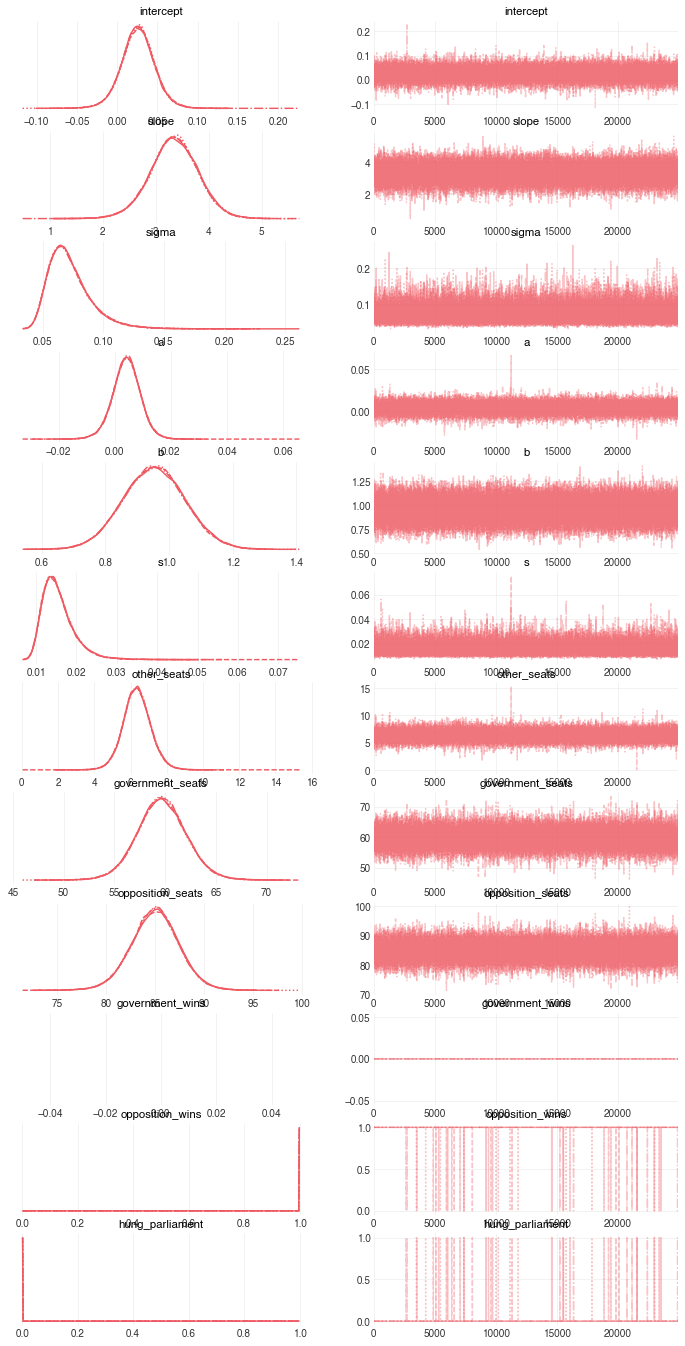

In [14]:
az.plot_trace(fit, var_names=['intercept', 'slope', 'sigma', 
                              'a', 'b', 's',
                              'other_seats', 'government_seats',
                              'opposition_seats', 'government_wins',
                              'opposition_wins', 'hung_parliament'])

## Visualisations

In [15]:
results_df = fit.to_frame()

In [16]:
results_df.columns

Index(['lp__', 'accept_stat__', 'stepsize__', 'treedepth__', 'n_leapfrog__',
       'divergent__', 'energy__', 'slope', 'intercept', 'sigma', 'a', 'b', 's',
       'other_seats', 'available_seats', 'government_seats',
       'opposition_seats', 'government_wins', 'opposition_wins',
       'hung_parliament'],
      dtype='object', name='parameters')

In [17]:
def plot_finalise(ax, title=None, xlabel=None, ylabel=None):
    
    # annotate the plot
    if title is not None:
        ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
        
    ax.figure.tight_layout(pad=1.1)    
    
    ax.figure.savefig(CHART_DIR+title+'.png', dpi=300)
    
    # close
    plt.show()
    plt.close()

In [21]:
def plot_seats_won(party, title, colour):
    sw = results_df[party].round(0).value_counts()
    sw = sw.sort_index() / sw.sum()
    sw.index = sw.index.astype(int)
    _, ax = plt.subplots()
    ax.bar(x=sw.index, height=sw, color=colour)
    plot_finalise(ax, title,
                  xlabel='Number of seats won',
                  ylabel='Probability')

### Seats won

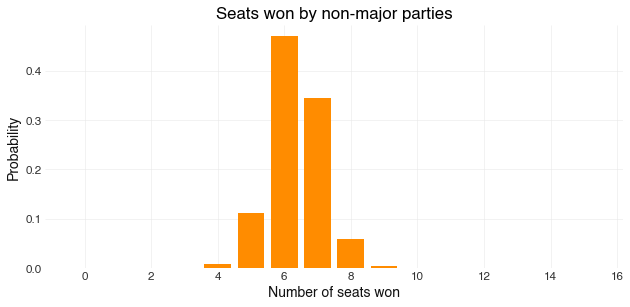

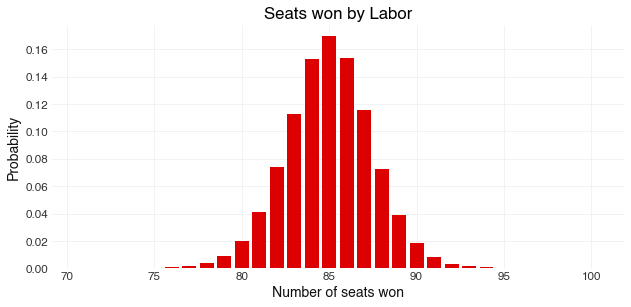

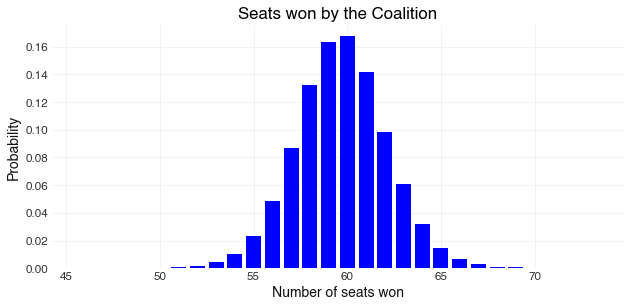

In [22]:
plot_seats_won('other_seats', 'Seats won by non-major parties', 'darkorange')
plot_seats_won('opposition_seats', 'Seats won by Labor', '#dd0000')
plot_seats_won('government_seats', 'Seats won by the Coalition', 'blue')

### House outcome

parameters
government_wins    0.00000
hung_parliament    0.00064
opposition_wins    0.99936
dtype: float64


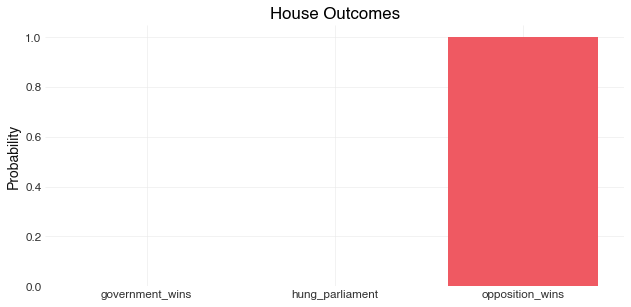

In [20]:
ho = results_df[['government_wins', 'opposition_wins', 'hung_parliament']].sum()
ho = (ho / ho.sum()).sort_values()
print(ho)
_, ax = plt.subplots()
ax.bar(x=ho.index, height=ho)
plot_finalise(ax, 'House Outcomes',
              xlabel=None,
              ylabel='Probability')